In [8]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import MinMaxScaler

In [9]:
# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

In [10]:
from datetime import datetime

# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
    chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label']]
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)

    return chunk[['text', 'encoded_label']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

# Run XGBoost first before running below, use if not have a matching input format validation

In [4]:
# # Combine relevant columns into a single text column
# with pd.read_csv("./output/validation.csv", chunksize=chunksize) as reader:
#     i = 0
#     for chunk in reader:
#         print ("----------------Processing chunk: ", i ,"-----------------------")
#         processed_chunk = process_chunk(chunk)
#         processed_data.append(processed_chunk)
#         i += 1

# print ("Finish text column generation, combining chunk....")
# # Combine all processed chunks into a single DataFrame
# processed_data = pd.concat(processed_data, ignore_index=True)
# #     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# # + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
# #     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
# #     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
# #     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
# #     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
# #     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

# processed_data

----------------Processing chunk:  0 -----------------------
----------------Processing chunk:  1 -----------------------
----------------Processing chunk:  2 -----------------------
----------------Processing chunk:  3 -----------------------
----------------Processing chunk:  4 -----------------------
----------------Processing chunk:  5 -----------------------
----------------Processing chunk:  6 -----------------------
----------------Processing chunk:  7 -----------------------
----------------Processing chunk:  8 -----------------------
----------------Processing chunk:  9 -----------------------
----------------Processing chunk:  10 -----------------------
----------------Processing chunk:  11 -----------------------
----------------Processing chunk:  12 -----------------------
----------------Processing chunk:  13 -----------------------
----------------Processing chunk:  14 -----------------------
----------------Processing chunk:  15 -----------------------
----------------Pr

,text,encoded_label
0,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
1,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
2,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
3,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
4,"2020-05-29 05:44:39+00:00,2023-03-05 14:31:47+...",1
...,...,...
16326932,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326933,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326934,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1
16326935,"2018-05-24 10:51:22+00:00,2023-05-01 02:27:59+...",1


In [5]:
# features = processed_data['text'].apply(split_string2)
# processed_data['text'] = features
# processed_data

,text,encoded_label
0,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
1,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
2,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
3,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
4,"[1590731079.0, 1678026707.0, 266.0, 0.0, 0.0, ...",1
...,...,...
16326932,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326933,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326934,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1
16326935,"[1527159082.0, 1682908079.0, 2599.0, 2.0562149...",1


In [6]:
# # Check for NaN and infinite values
# if processed_data.isnull().values.any():
#     print("There are NaN values in the processed_data dataframe")
    
# # Convert it to float32 for Random Forest library
# from sklearn.preprocessing import MinMaxScaler

# # Convert the "text" column to a numpy array
# text_array = np.array(list(processed_data["text"]))

# # Scale down the values in the array to the range [0, 1]
# scaler = MinMaxScaler()
# text_array_scaled = scaler.fit_transform(text_array)

# # Cast the scaled array to the float32 data type
# text_array_scaled = text_array_scaled.astype(np.float32)

# # Create a new dataframe with the scaled "text" column and the original "encoded_label" column
# new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# # Replace the original "processed_data" dataframe with the new dataframe
# processed_data = new_df

In [7]:
# processed_data

,text,encoded_label
0,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
1,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
2,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
3,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
4,"[0.63122845, 0.9782396, 5.9411166e-05, 0.0, 0....",1
...,...,...
16326932,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326933,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326934,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1
16326935,"[0.36666092, 0.99976754, 0.0005824536, 5.66271...",1


In [8]:
# # We have 22 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
# column_names = [f'feature_{i}' for i in range(0, 22)]

# # Create a new DataFrame with separate columns
# encoded_labels = processed_data["encoded_label"]
# processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
# processed_data_expanded.dropna(inplace=True)
# processed_data_expanded["encoded_labels"] = encoded_labels

# processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,encoded_labels
0,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
1,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
2,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
3,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
4,0.631228,0.978240,0.000059,0.000000,0.0,0.0,0.000000,0.00006,0.0,0.005379,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16326932,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326933,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326934,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1
16326935,0.366661,0.999768,0.000582,0.000057,0.0,0.0,0.038446,0.00000,0.0,0.000982,...,0.016735,0.000105,0.038365,0.854204,0.009724,0.008763,0.000004,2.957059e-08,0.000022,1


# If have a saved matching input format validation

In [26]:
# # train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
# processed_data_expanded = pd.read_csv('./output/scaled_to_only_validation_one_col.csv') # scaled_to_only_validation_one_col scaled_validation_one_col
# # processed_data_expanded = processed_data_expanded.drop('Unnamed: 0', axis=1)

# processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,encoded_tags
0,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202
1,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202
2,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202
3,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202
4,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745637,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,...,0.791094,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011,191
1745638,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,...,0.791094,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011,191
1745639,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,...,0.791094,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011,191
1745640,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,...,0.606367,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019,202


In [33]:
# # Define the features and the target
# # feature_12 is Tags --> remove
# processed_data_expanded = processed_data_expanded.drop('feature_12', axis=1)

# # Define the desired column names
# new_column_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
#                     'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
#                     'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
#                     'feature_18', 'feature_19', 'encoded_tags']

# # Rename the columns
# processed_data_expanded.columns = new_column_names

# # scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
# X_val = processed_data_expanded.drop('encoded_tags', axis=1)
# y_val = processed_data_expanded['encoded_tags']

# X_val

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,0.361471,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019
1,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,0.361471,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019
2,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,0.361471,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019
3,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,0.361471,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019
4,0.630983,0.979582,0.002110,0.000000,0.00000,0.0,0.000000,0.002113,0.000,0.001864,0.361471,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745637,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,0.650744,0.0,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011
1745638,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,0.650744,0.0,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011
1745639,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,0.650744,0.0,0.000095,0.032895,0.680964,1.000000,0.468757,1.659686e-07,0.000000e+00,0.000011
1745640,0.359262,0.999782,0.021137,0.000057,0.00122,0.0,0.350196,0.000003,0.001,0.000335,0.650744,0.0,0.000104,0.030820,0.857497,0.239467,0.366357,2.904739e-02,7.289669e-295,0.000019


In [34]:
# # Remove the Tag class with below 10 count
# counts = y_val.value_counts()

# y_val = y_val[y_val.isin(counts[counts > 10].index)] # 10 is cutof as mentioned in Preprocessing step
# X_val = X_val.loc[y_val.index]

# XGBoost

Since XGBoost can manually use adjust the scale of minority class, using non-oversampling/undersampling data is beneficial because it avoids duplicate data

In [11]:
# train_processed_data = pd.read_csv('./output/non_nan_balanced_data.csv')
train_processed_data = pd.read_csv('./output/one_text_col_data.csv')

train_processed_data

,text,encoded_tags
0,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
1,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
2,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
3,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
4,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
...,...,...
5915131,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",203
5915132,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217
5915133,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217
5915134,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217


In [12]:
# one_text_col_data
features = train_processed_data['text'].apply(split_string2)
train_processed_data['text'] = features
train_processed_data

,text,encoded_tags
0,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",217
1,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",217
2,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",217
3,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",217
4,"[1590487397.0, 1682382803.0, 2609.0, 0.0, 6e+1...",217
...,...,...
5915131,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",203
5915132,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",217
5915133,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",217
5915134,"[1525148883.0, 1682954963.0, 26089.0, 2.056214...",217


In [13]:
# # Check for NaN and infinite values
# if train_processed_data.isnull().values.any():
#     print("There are NaN values in the processed_data dataframe")
    
# # Convert it to float32 for Random Forest library
# from sklearn.preprocessing import MinMaxScaler

# # Convert the "text" column to a numpy array
# text_array = np.array(list(train_processed_data["text"]))

# # Scale down the values in the array to the range [0, 1]
# scaler = MinMaxScaler()
# text_array_scaled = scaler.fit_transform(text_array)

# # Cast the scaled array to the float32 data type
# text_array_scaled = text_array_scaled.astype(np.float32)

# # Create a new dataframe with the scaled "text" column and the original "encoded_label" column
# new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': train_processed_data['encoded_label']})

# # Replace the original "processed_data" dataframe with the new dataframe
# train_processed_data = new_df



# Check for NaN and infinite values
if train_processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert list of lists in text column to DataFrame
text_df = pd.DataFrame(train_processed_data['text'].to_list())

# Replace infinite values with NaN
text_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with a large number (for example, max float64)
text_df.fillna(np.finfo(np.float64).max, inplace=True)

# Scale values using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(text_df)

# Replace original text column with scaled values
train_processed_data['text'] = list(scaled_values)

E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
E:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [14]:
train_processed_data

,text,encoded_tags
0,"[0.6234549535280092, 0.9976107871085054, 0.002...",217
1,"[0.6234549535280092, 0.9976107871085054, 0.002...",217
2,"[0.6234549535280092, 0.9976107871085054, 0.002...",217
3,"[0.6234549535280092, 0.9976107871085054, 0.002...",217
4,"[0.6234549535280092, 0.9976107871085054, 0.002...",217
...,...,...
5915131,"[0.35465242571638456, 0.9999752544213694, 0.02...",203
5915132,"[0.35465242571638456, 0.9999752544213694, 0.02...",217
5915133,"[0.35465242571638456, 0.9999752544213694, 0.02...",217
5915134,"[0.35465242571638456, 0.9999752544213694, 0.02...",217


In [31]:
# We have 21 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
train_column_names = [f'feature_{i}' for i in range(0, 21)]

# Create a new DataFrame with separate columns
train_encoded_labels = train_processed_data["encoded_tags"]
train_processed_data_expanded = pd.DataFrame(train_processed_data['text'].tolist(), columns=train_column_names, index=train_processed_data.index)
train_processed_data_expanded.dropna(inplace=True)
train_processed_data_expanded["encoded_tags"] = train_encoded_labels

# feature_12 is Tags --> remove
train_processed_data_expanded = train_processed_data_expanded.drop('feature_12', axis=1)

# Define the desired column names
new_column_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                    'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
                    'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
                    'feature_18', 'feature_19', 'encoded_tags']

# Rename the columns
train_processed_data_expanded.columns = new_column_names

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
1,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
2,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
3,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
4,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915131,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.0,0.000091,0.018721,0.680482,1.000000,0.465448,7.123401e-07,2.652135e-296,0.000009,203
5915132,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
5915133,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
5915134,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.0,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217


In [32]:
train_processed_data_expanded.to_csv("./output/scaled_train_data.csv")

# If have saved train data

In [2]:
train_processed_data_expanded = pd.read_csv('./output/scaled_train_data.csv')
train_processed_data_expanded = train_processed_data_expanded.drop('Unnamed: 0', axis=1)

train_processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,encoded_tags
0,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
1,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
2,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
3,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
4,0.623455,0.997611,0.002130,0.000000,3.501077e-07,0.0,0.000000,0.002130,7.599510e-07,0.000547,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915131,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.785258,0.000091,0.018721,0.680482,1.000000,0.465448,7.123401e-07,2.652135e-296,0.000009,203
5915132,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
5915133,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217
5915134,0.354652,0.999975,0.021302,0.000057,5.835128e-05,0.0,0.351985,0.000002,6.332925e-05,0.000094,...,0.605882,0.000104,0.027793,0.860078,0.239291,0.361326,2.854600e-02,1.905827e-293,0.000015,217


In [35]:
# Define the features and the target
# scale_pos_weight = len(processed_data_expanded[processed_data_expanded['encoded_label'] == 1]) / len(processed_data_expanded[processed_data_expanded['encoded_label'] == 0])
X = train_processed_data_expanded.drop('encoded_tags', axis=1)
y = train_processed_data_expanded['encoded_tags']

# Remove the Tag class with below 10 count
counts = y.value_counts()
y_filtered = y[y.isin(counts[counts > 10].index)] # 10 is cutof as mentioned in Preprocessing step
X_filtered = X[y.isin(counts[counts > 10].index)]

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=25, stratify=y_filtered)

In [36]:
# # Calculate the scale_pos_weight if you haven't done it yet
# scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
# scale_pos_weight

import xgboost as xgb

# Compute class weights
class_weights = y_train.value_counts().min() / y_train.value_counts()

# Convert the dataset into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set weight
weights = y_train.map(class_weights)
dtrain.set_weight(weights)

In [21]:
# import xgboost as xgb

# clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight) # 0.99 means a more balanced dataset than scale_pos_weight
# clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [22]:
# clf.save_model("./temp/xgb_model.bin") # _099

# Training

In [37]:
# Define parameters of the model
params = {
    'objective': 'multi:softprob',  # for multiclass classification
    'num_class': len(np.unique(y)),  # number of classes
    'eval_metric': 'mlogloss'  # evaluation metric for multiclass
}

# Watch list to see the evaluation metric on both training and test set
watchlist = [(dtrain, 'train'), (dtest, 'test')]

# Training the model
# Note: 10 round is overfitting (100% across the board) 
# even if loss for both train and test did not convergence
# Note: 3 round seems to be fine for this data set, 93% precision, 95% recall and 97.69% ROC AUC
bst = xgb.train(params, dtrain, num_boost_round=3, evals=watchlist, verbose_eval=True)

[0]	train-mlogloss:4.36474	test-mlogloss:4.43390
[1]	train-mlogloss:3.21750	test-mlogloss:3.37016
[2]	train-mlogloss:2.15095	test-mlogloss:2.35059


In [38]:
bst.save_model("./output/xgb_model.bin")

# Test Data

In [ ]:
import xgboost as xgb

bst = xgb.Booster()
bst.load_model("./output/xgb_model.bin") # _099

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

dtest = xgb.DMatrix(X_test, label=y_test)

# Predict the class probabilities on the test set
y_pred_prob = bst.predict(dtest)

# get the class with the highest probability for each instance
y_pred_max_prob = np.argmax(y_pred_prob, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_max_prob))

# # Predict and evaluate the model
# y_val_pred = clf.predict(X_val)
# y_val_pred

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3587
           1       1.00      1.00      1.00      4402
           4       1.00      1.00      1.00      2252
           5       1.00      1.00      1.00         2
           6       1.00      0.99      1.00       291
           7       1.00      0.92      0.96      1291
           8       0.99      1.00      1.00       385
           9       1.00      1.00      1.00      4660
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00      3572
          12       1.00      1.00      1.00        31
          13       1.00      0.82      0.90      2626
          14       1.00      0.97      0.98        93
          15       1.00      1.00      1.00        26
          16       1.00      1.00      1.00      4993
          17       0.90      1.00      0.95       775
          18       1.00      1.00      1.00       354
          19       1.00    

E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve

# Binarize the output
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_test_pred_bin = lb.transform(y_pred_max_prob)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_test_pred_bin, average='macro')
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.9769084864011118


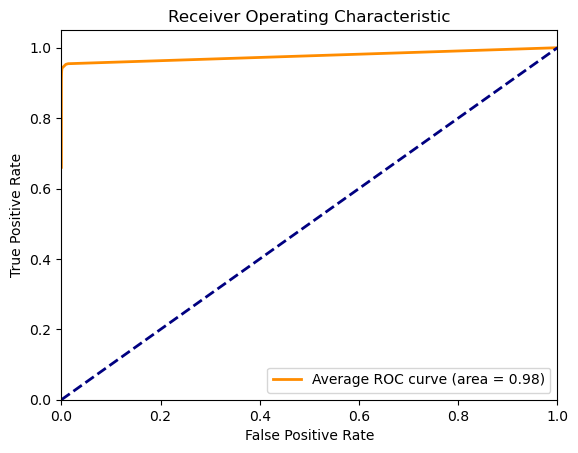

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot average ROC curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc["macro"])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('./output/xgb.png')
plt.show()

In [8]:
# from sklearn.metrics import roc_curve, auc

# precision = precision_score(y_val, y_val_pred)
# recall = recall_score(y_val, y_val_pred)
# f1 = f1_score(y_val, y_val_pred)

# # Calculate the probabilities for the ROC AUC score
# roc_auc = roc_auc_score(y_val, y_val_pred)

# print(f"Precision: {precision:.3f}")
# print(f"Recall: {recall:.3f}")
# print(f"F1-score: {f1:.3f}")
# print(f"ROC AUC: {roc_auc:.3f}")

Precision: 1.000
Recall: 0.998
F1-score: 0.999
ROC AUC: 0.989


In [9]:
# print (classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     27549
           1       1.00      1.00      1.00   1718093

    accuracy                           1.00   1745642
   macro avg       0.95      0.99      0.97   1745642
weighted avg       1.00      1.00      1.00   1745642



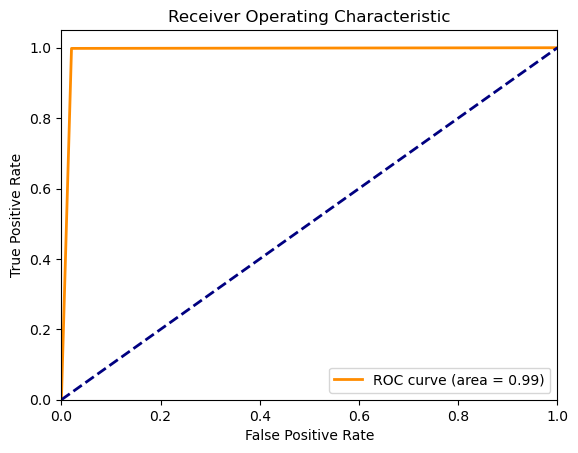

In [10]:
# # Compute ROC curve and ROC area
# fpr, tpr, _ = roc_curve(y_val, y_val_pred)
# roc_auc = auc(fpr, tpr)

# # Plot
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # random classifier
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")

# plt.savefig('xgb.png')
# plt.show()

In [12]:
# from sklearn.metrics import average_precision_score

# # XGBoost
# xgb_auprc = average_precision_score(y_val, y_val_pred_max_prob)
# print(f'XGBoost AUPRC: {xgb_auprc}')

XGBoost AUPRC: 0.9996413502662841


In [20]:
# processed_data_expanded.to_csv("./output/scaled_validation_one_col.csv")
# train_processed_data_expanded.to_csv("./output/scaled_train_one_col.csv")

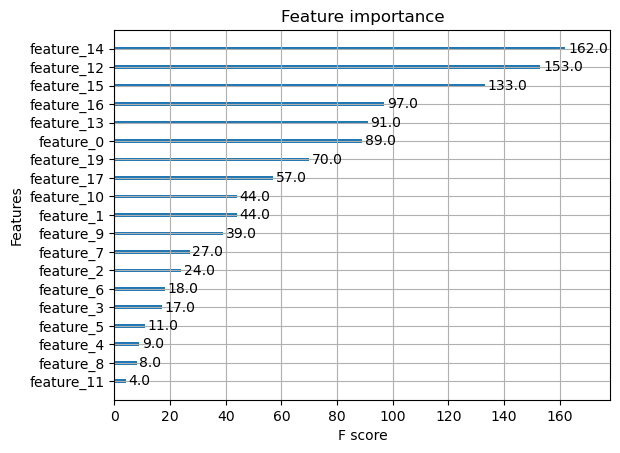

In [40]:
import matplotlib.pyplot as plt

# assuming that bst is your trained model
# e.g. bst = xgb.train(params, dtrain, num_rounds)
xgb.plot_importance(bst)
plt.show()

FScore

f14 : 162 StdDevBalance --> tag cluster

f12: 153 MeanNumTransactions --> tag cluster

f15: 133 ClusterLifetime --> tag cluster

f16: 97 NumWithdrawalsPerMonth --> tag cluster

f13: 91 MeanBalance --> tag cluster

f0: 89 block_timestamp_min --> address

f19: 70 MeanSentETHPerLifetime --> tag cluster

E:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


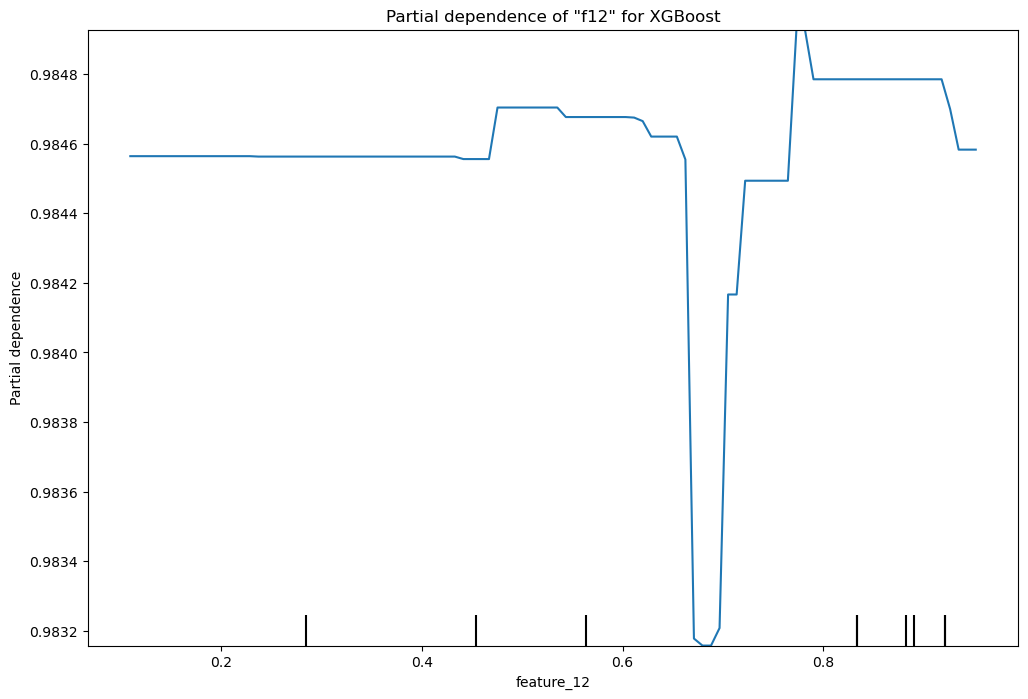

In [23]:
# from sklearn.inspection import plot_partial_dependence
# import matplotlib.pyplot as plt

# # # Assuming 'data' is your DataFrame, and 'target' is your target variable
# # data = pd.read_csv('your_data.csv')  # replace 'your_data.csv' with your actual data file
# # target = data['your_target']  # replace 'your_target' with your actual target column name

# # # Remove the target from the input data
# # data = data.drop('your_target', axis=1)

# # For XGBoost
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_partial_dependence(bst, X_val, ['feature_12'], ax=ax)
# plt.title('Partial dependence of "f12" for XGBoost')
# plt.show()

In general, it seems to have no relationship. However, As can be seen from 0.5 x-axis forward, the Parial dependence values are U-shapes --> non-linear relationship